In [22]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
i

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow_addons as tfa
import dill

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K

In [23]:
df=pd.read_csv("../input/techbomb2/main.csv")

df=df[['Date', 'Time',
       'Current', 'Humidity', 'Temperature', 'Flow', 'Job Temp', 'Voltage',
       'Defect']]

# Filling Missing values
df.loc[266339,'Current']=0.41
df.loc[524124,'Current']=1.07
df.loc[814609,'Current']=-0.6

# Dropping time and date
df.drop(['Date', 
         'Time'
        ], axis=1, inplace=True)

# Mapping Defects
def mapping_defects(elem):
    if 'No Defect' in elem:
        return 0
    elif 'Tungsten Inclusion' in elem:
        return 1
    elif 'Porosity' in elem:
        return 2
    else:
        pass
    
df['Defect'] = df['Defect'].map(lambda x:mapping_defects(x))
df['Temperature']=abs(df['Temperature'])
df['Humidity']=abs(df['Humidity'])


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
# Removing Outliers
df=df[df.Humidity < np.percentile(df.Humidity,99)]
df=df[df.Temperature < np.percentile(df.Temperature,99)]

df=df[df["Job Temp"] < np.percentile(df["Job Temp"],96)]

In [26]:
def scaling(data):
    scaler=MinMaxScaler()
    scaler = scaler.fit(data[['Current', 'Humidity', 'Temperature', 'Flow', 'Job Temp', 'Voltage']])
    
    data[['Current', 'Humidity', 'Temperature', 'Flow', 'Job Temp', 'Voltage']] = scaler.transform(data[['Current', 'Humidity', 'Temperature', 'Flow', 'Job Temp', 'Voltage']])

    return data
 
df = scaling(df)

In [28]:
train, test = df.loc[:789201], df.loc[789201:] # splitting data based on sequence


In [30]:

def to_sequences(x, y, seq_size):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):

        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)


In [32]:
seq_size = 25 # stores 25 rows of previous data

trainX, trainY = to_sequences(train[['Current', 'Humidity', 'Temperature', 'Flow', 'Job Temp', 'Voltage']], train[['Defect']], seq_size)
testX, testY = to_sequences(test[['Current', 'Humidity', 'Temperature', 'Flow', 'Job Temp', 'Voltage']], test[['Defect']], seq_size)

In [33]:
print(np.any(np.isnan(trainX)))
print(np.any(np.isnan(trainY)))

print(np.any(np.isnan(testX)))
print(np.any(np.isnan(testY)))

False
False
False
False


In [34]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(trainY), class_weight.compute_class_weight(class_weight = 'balanced', classes=np.unique(trainY[:,0]), 
               y=trainY[:,0]))) 

class_weights

{0: 0.33538787002306614, 1: 70.0055121266787, 2: 244.32144106330884}

In [35]:
del train, test

In [36]:
oneHot=OneHotEncoder()
oneHot.fit(trainY.reshape(-1,1))

trainY=oneHot.transform(trainY.reshape(-1,1)).toarray()
testY =oneHot.transform(testY.reshape(-1,1)).toarray()


In [40]:
def get_mape(y_true, y_pred):
#     loss = 100 * abs((y_true - y_pred) / y_true)
    mape = 100*K.abs(((y_true - y_pred) / y_true))
    return mape

In [71]:
def get_model(in_shape):
    
    inputs= tf.keras.Input(shape=(in_shape[1],in_shape[2]))
    x=LSTM(512,activation='tanh', input_shape=(in_shape[1],in_shape[2]),return_sequences=True)(inputs)
    x=LSTM(384,activation='tanh',return_sequences=True)(x)
    x=LSTM(256,activation='tanh',return_sequences=True)(x)
    x=LSTM(128,activation='tanh')(x)
    out_class=Dense(3,activation='softmax')(x)
    
    model=tf.keras.Model(inputs=inputs, outputs=[out_class])
    
    model.compile(loss=[
                        'categorical_crossentropy',
#                         tf.keras.metrics.mean_absolute_percentage_error
                       ],
                         optimizer=tf.keras.optimizers.RMSprop(0.00001),
                         metrics=['categorical_accuracy', 
                                  tfa.metrics.F1Score(num_classes=3,average='weighted'),
#                                   tf.keras.metrics.mean_absolute_percentage_error
                                 ])

    return model  

In [72]:
inputshape_X=(trainX.shape)
model=get_model(inputshape_X)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 25, 6)]           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 25, 512)           1062912   
_________________________________________________________________
lstm_27 (LSTM)               (None, 25, 384)           1377792   
_________________________________________________________________
lstm_28 (LSTM)               (None, 25, 256)           656384    
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 3,294,595
Trainable params: 3,294,595
Non-trainable params: 0
_________________________________________________

In [73]:
import gc

gc.collect()

8292

In [74]:

reduce_lr=ReduceLROnPlateau(monitor='f1_score',factor=0.1,patience=2, min_delta=1e-4, verbose=1, min_lr=1e-11, mode='max')

weights=ModelCheckpoint('LSTM_Weld.hdf5',
                       save_best_only=True,
                       monitor='f1_score',
                       verbose=1,
                       save_weights_only=False,mode='max')

early_stopping=EarlyStopping(monitor='f1_score',patience=4,restore_best_weights=True,mode='max')

callbacks=[reduce_lr,
            weights,
            early_stopping,

          ]

In [75]:
history = model.fit(trainX, trainY, epochs=25, batch_size=32, validation_data=(testX, testY), shuffle=False,
                    class_weight=class_weights,
                    callbacks=callbacks
                   )

Epoch 1/25
21829/21829 [==============================] - 353s 16ms/step - loss: 1.3111 - categorical_accuracy: 0.7692 - f1_score: 0.8643 - val_loss: 0.7527 - val_categorical_accuracy: 0.9891 - val_f1_score: 0.9837

Epoch 00001: f1_score improved from -inf to 0.86430, saving model to LSTM_Weld.hdf5
Epoch 2/25
21829/21829 [==============================] - 348s 16ms/step - loss: 1.3059 - categorical_accuracy: 0.7811 - f1_score: 0.8718 - val_loss: 0.7170 - val_categorical_accuracy: 0.9890 - val_f1_score: 0.9836

Epoch 00002: f1_score improved from 0.86430 to 0.87176, saving model to LSTM_Weld.hdf5
Epoch 3/25
21829/21829 [==============================] - 349s 16ms/step - loss: 1.3399 - categorical_accuracy: 0.8229 - f1_score: 0.8973 - val_loss: 0.6582 - val_categorical_accuracy: 0.9891 - val_f1_score: 0.9837

Epoch 00003: f1_score improved from 0.87176 to 0.89734, saving model to LSTM_Weld.hdf5
Epoch 4/25
21829/21829 [==============================] - 348s 16ms/step - loss: 1.3260 - cate

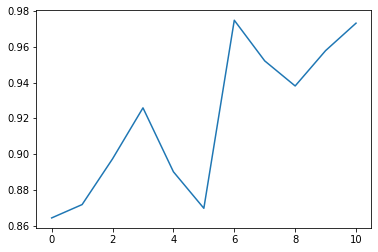

In [87]:
plt.plot(history.history['f1_score'])

[0.864303469657898,
 0.8717645406723022,
 0.8973392844200134,
 0.9258601069450378,
 0.8901095390319824,
 0.8696919679641724,
 0.9748552441596985,
 0.952127993106842,
 0.9381019473075867,
 0.9578670859336853,
 0.9732232093811035]